In [70]:
from gibbs.dataclass import GibbsResult
import matplotlib.pyplot as plt
import numpy as np
from gibbs.learning.bayesian_learning import BayesianLearning
from gibbs.learning.constraint_matrix import ConstraintMatrixFactory
from qiskit.quantum_info import Statevector
from gibbs.learning.klocal_pauli_basis import KLocalPauliBasis
from scipy.linalg import block_diag
from scipy.sparse import bmat
from qiskit.quantum_info import state_fidelity
from gibbs.utils import number_of_elements, simple_purify_hamiltonian, spectral_dec
# plt.rcParams['text.usetex'] = True

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [71]:
n=4
k=2
nfields = 2
shots = 1e5
prep_noise = 1e-1
basisH = KLocalPauliBasis(k,n,False)
cmat = ConstraintMatrixFactory(n,k,k+1)
c_original = np.zeros(basisH.size)
c_original[basisH.pauli_to_num("XX"+"I"*(n-2)):basisH.pauli_to_num("I"*(n-2)+"XX")+1]=1
c_original_prior = c_original.copy()
c_original[basisH.pauli_to_num("XX"+"I"*(n-2)):] += np.random.normal(0,prep_noise,size=c_original[basisH.pauli_to_num("XX"+"I"*(n-2)):].size)
print(f"We will need to sample {KLocalPauliBasis(2*k,n,False).size} Paulis for each one of the states. In total,{int((nfields+1)*shots*KLocalPauliBasis(2*k,n,False).size):.1E}")

We will need to sample 255 Paulis for each one of the states. In total,7.6E+07


We start with a hamiltonian error of:0.38669956267967787 and end up with 0.09152596812764538 
The prior fidelity is: 0.9796897736076233 and the posterior fidelity is: 0.9988403750288944


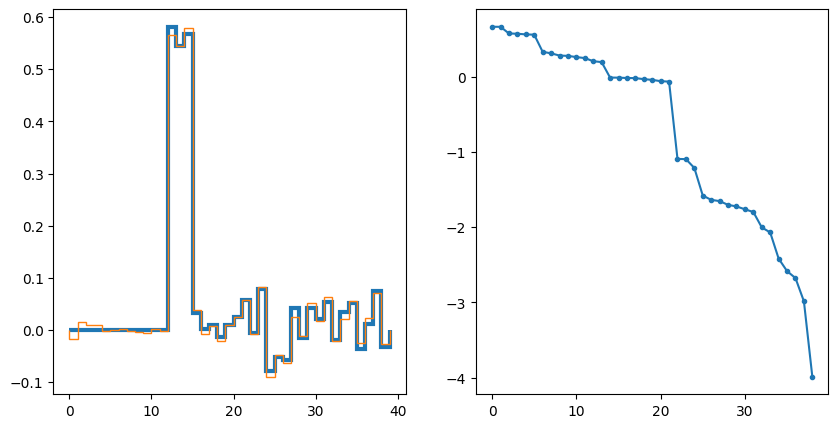

In [72]:
s,v = spectral_dec(cmat.create_constraint_matrix(simple_purify_hamiltonian(basisH.vector_to_pauli_op(c_original)),shots=shots))
candidate = v[-1].copy(); candidate /= np.linalg.norm(candidate)
if np.linalg.norm(c_original/np.linalg.norm(c_original) + candidate) < np.linalg.norm(c_original/np.linalg.norm(c_original) - candidate):
    candidate = -candidate
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].stairs(c_original/np.linalg.norm(c_original),lw=3)
ax[0].stairs(candidate)
ax[1].plot(np.log(s),marker=".")
print(f"We start with a hamiltonian error of:{np.linalg.norm(c_original_prior-c_original)} and end up with {np.linalg.norm(candidate*np.linalg.norm(c_original)-c_original)} ")
print(f"The prior fidelity is: {state_fidelity(simple_purify_hamiltonian(basisH.vector_to_pauli_op(c_original_prior)),simple_purify_hamiltonian(basisH.vector_to_pauli_op(c_original)))} and the posterior fidelity is: {state_fidelity(simple_purify_hamiltonian(basisH.vector_to_pauli_op(candidate*np.linalg.norm(c_original))),simple_purify_hamiltonian(basisH.vector_to_pauli_op(c_original)))}")

In [73]:
control_fields = [np.zeros(basisH.size) for _ in range(nfields+1)]
for i,cf in enumerate(control_fields[1:]):
    cf[i*5:(i+1)*5] = -0.25
    # cf += np.random.normal(0,1e-2)
states = [simple_purify_hamiltonian(basisH.vector_to_pauli_op(c_original+cf)) for cf in control_fields]
constraint_matrices = [cmat.create_constraint_matrix(state,shots=shots) for state in states]

We start with a hamiltonian error of:0.38669956267967787 and end up with 0.13902634928047397 
The prior fidelity is: 0.9796897736076233 and the posterior fidelity is: 0.9988087741796732


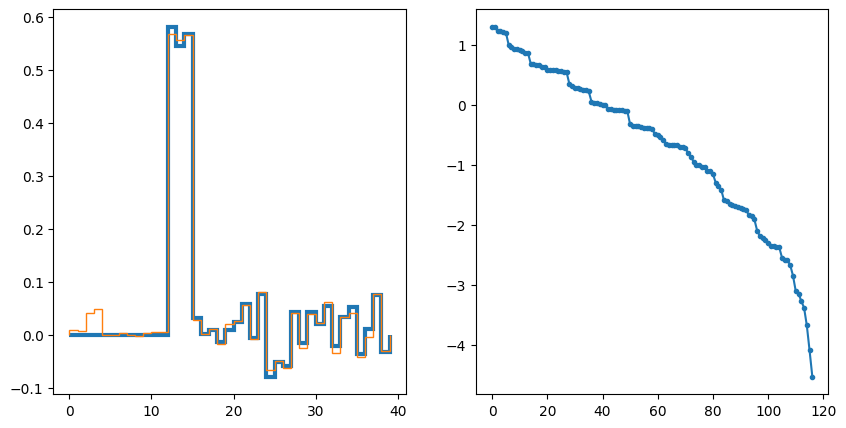

In [74]:
A = bmat([[constraint_matrices[0]]+[None]*(len(constraint_matrices)-1)]+[[c]+[None]*i + [c] +[None]*(len(constraint_matrices)-i-2) for i,c in enumerate(constraint_matrices[1:])])
s,v = spectral_dec(A)
candidate = v[-1][:c_original.size].copy(); candidate /= np.linalg.norm(candidate)
if np.linalg.norm(c_original/np.linalg.norm(c_original) + candidate) < np.linalg.norm(c_original/np.linalg.norm(c_original) - candidate):
    candidate = -candidate  
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].stairs(c_original/np.linalg.norm(c_original),lw=3)
ax[0].stairs(candidate)
ax[1].plot(np.log(s),marker=".")
print(f"We start with a hamiltonian error of:{np.linalg.norm(c_original_prior-c_original)} and end up with {np.linalg.norm(candidate*np.linalg.norm(c_original)-c_original)} ")
print(f"The prior fidelity is: {state_fidelity(simple_purify_hamiltonian(basisH.vector_to_pauli_op(c_original_prior)),simple_purify_hamiltonian(basisH.vector_to_pauli_op(c_original)))} and the posterior fidelity is: {state_fidelity(simple_purify_hamiltonian(basisH.vector_to_pauli_op(candidate*np.linalg.norm(c_original))),simple_purify_hamiltonian(basisH.vector_to_pauli_op(c_original)))}")

In [75]:
initial_arguments = {
    "states":states,
    "control_fields": control_fields,
    "constraint_matrix_factory": ConstraintMatrixFactory(4,2,2),
    "prior_mean": c_original_prior,
    "prior_covariance": (prep_noise,1e-5),
    "sampling_std": 1/np.sqrt(shots),
    "shots": shots
    }
bl = BayesianLearning(**initial_arguments)
bl.constraint_matrix(0)

<39x39 sparse matrix of type '<class 'numpy.complex128'>'
	with 564 stored elements in Compressed Sparse Row format>

In [76]:
cmat = bl.block_control_matrix(bl.constraint_matrices)
x_ideal = np.concatenate([c_original,*control_fields[1:]])
bl._cost_function(x_ideal,cmat)

(0.07103654880921885, 1.495365517766541)

In [77]:
update = bl.update_mean()


(117,) (117, 117)


/home/drudis/python_environements/test_easy_instalation/lib64/python3.10/site-packages/scipy/optimize/_differentiable_functions.py:107: ComplexWarning: Casting complex values to real discards the imaginary part
  self.x = np.atleast_1d(x0).astype(float)
/home/drudis/python_environements/test_easy_instalation/lib64/python3.10/site-packages/scipy/optimize/_differentiable_functions.py:243: ComplexWarning: Casting complex values to real discards the imaginary part
  self.x = np.atleast_1d(x).astype(float)


The time it takes for minimize is: 160.6194109916687 for the rest: 0.07481241226196289
The cost function ends up with a value of:0.4080432376801554, it started with a value of 1.5664020665757652


In [78]:
cov = bl.update_cov(update)

We start with a hamiltonian error of:0.38669956267967787 and end up with 0.3132340172603306 
The prior fidelity is: 0.9796897736076233 and the posterior fidelity is: 0.9878469544281482


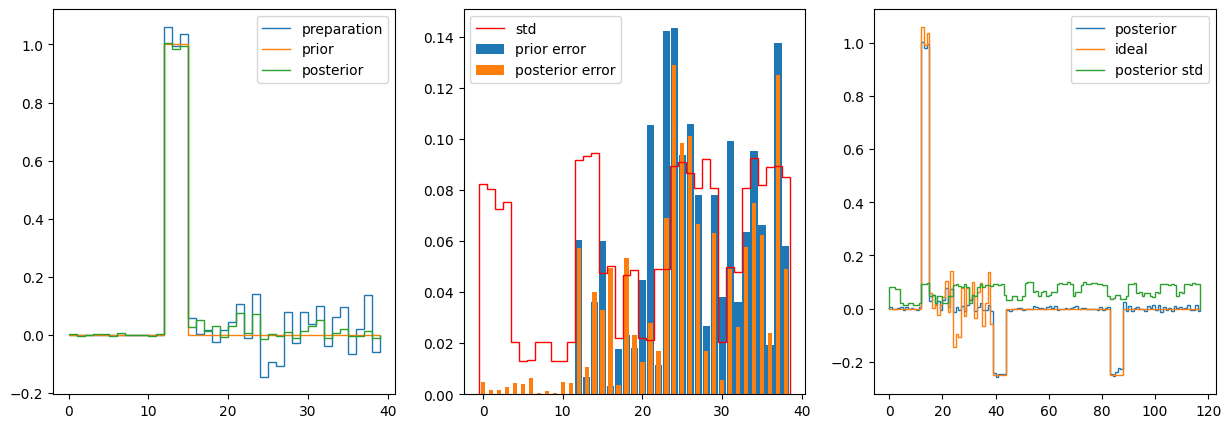

In [79]:
fig,ax = plt.subplots(1,3,figsize=(15,5))
ax[0].stairs(c_original,label="preparation")
ax[0].stairs(c_original_prior,label = "prior")
ax[0].stairs(update[:c_original.size],label="posterior")
ax[0].legend()
width = 0.9
ax[1].bar(np.arange(bl.size),np.abs(c_original-c_original_prior),width,label="prior error",lw=2,fill=True)
ax[1].bar(np.arange(bl.size),np.abs(c_original-update[:c_original.size]),0.6*width,label="posterior error",fill=True)
ax[1].stairs(cov.diagonal()[:c_original.size],np.arange(bl.size+1)-1/2,label="std",color="red")
ax[1].legend()
ax[2].stairs(update,label="posterior")
ax[2].stairs(x_ideal,label="ideal")
ax[2].stairs(cov.diagonal(),label="posterior std")
ax[2].legend()
print(f"We start with a hamiltonian error of:{np.linalg.norm(c_original_prior-c_original)} and end up with {np.linalg.norm(update[:c_original.size]-c_original)} ")
print(f"The prior fidelity is: {state_fidelity(simple_purify_hamiltonian(basisH.vector_to_pauli_op(c_original_prior)),simple_purify_hamiltonian(basisH.vector_to_pauli_op(c_original)))} and the posterior fidelity is: {state_fidelity(simple_purify_hamiltonian(basisH.vector_to_pauli_op(update[:c_original.size])),simple_purify_hamiltonian(basisH.vector_to_pauli_op(c_original)))}")